[Local](./ch03.ipynb),
[Github](https://github.com/renyuanL/_ryDsp2020/blob/master/code/ch03.ipynb),
[Colab](https://colab.research.google.com/github/renyuanL/_ryDsp2020/blob/master/code/ch03.ipynb)


# Chapter 3  Non-periodic signals

The signals we have worked with so far are periodic, which means that they repeat forever. It also means that the frequency components they contain do not change over time. In this chapter, we consider `non-periodic` signals, whose frequency components do change over time. In other words, pretty much all sound signals.

This chapter also presents `spectrograms`, a common way to visualize non-periodic signals.

The code for this chapter is in chap03.ipynb, which is in the repository for this book (see Section 0.2). You can also view it at http://tinyurl.com/thinkdsp03.

## 3.1  Linear chirp

![](http://greenteapress.com/thinkdsp/html/thinkdsp012.png)

Figure 3.1: Chirp waveform near the beginning, middle, and end.

----

We’ll start with a chirp, which is a signal with variable frequency. thinkdsp provides a Signal called Chirp that makes a sinusoid that sweeps linearly through a range of frequencies.

Here’s an example that sweeps from 220 to 880 Hz, which is two octaves from A3 to A5:

```python
signal= thinkdsp.Chirp(start=220, end=880)
wave=   signal.make_wave()
```

Figure 3.1 shows segments of this wave near the beginning, middle, and end. It’s clear that the frequency is increasing.

In [88]:
import thinkdsp
signal= thinkdsp.Chirp(start=220, end=880)
wave=   signal.make_wave()

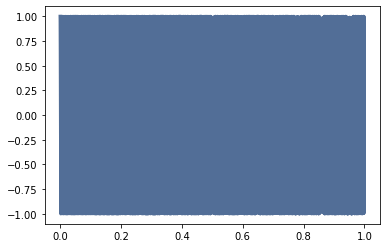

In [89]:
wave.plot()
wave.make_audio()

[Chirp](https://en.wikipedia.org/wiki/Chirp)

A chirp is a signal in which the frequency increases (up-chirp) or decreases (down-chirp) with time. In some sources, the term chirp is used interchangeably with sweep signal.[1]

[Hear Birds chirpping](https://upload.wikimedia.org/wikipedia/commons/6/68/Turdus_merula_male_song_at_dawn%2820s%29.ogg)
![](https://upload.wikimedia.org/wikipedia/commons/thumb/b/ba/Solsort.jpg/300px-Solsort.jpg)    

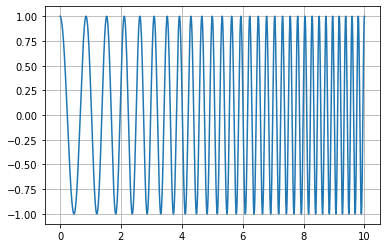

In [90]:
import numpy as np
import matplotlib.pyplot as pl

import scipy.signal

#scipy.signal.chirp?

t= np.linspace(0, 10, 10001) # 10 sec
w= scipy.signal.chirp(t, 
                      f0= 1, # starting at 1 Hz 
                      f1= 5, # ending at 5 Hz
                      t1=10, # within 10 sec
                      method= 'linear')
pl.plot(t,w)
pl.grid()

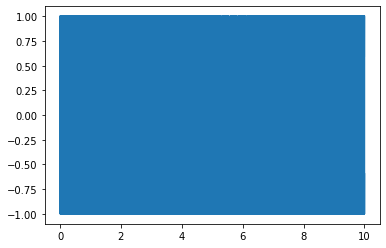

In [91]:
import IPython.display
t= np.linspace(0, 10, 10000*10+1) # 10 sec, sampingrate= 10000
w= scipy.signal.chirp(t, 
                      f0= 100, # starting at 100 Hz 
                      f1= 500, # ending at 500 Hz
                      t1=  10, # within 10 sec
                      method= 'linear')
pl.plot(t,w)

IPython.display.Audio(w, rate=10000)

For a simple sinusoidal signal with constant frequency, 
we have

$
x= cos(θ)\\
θ= ω \cdot t\\
$

Considering

$
θ= \frac{1}{2}α \cdot t^2
$

----
for
$
θ= ω \cdot t\\
\frac{dθ}{dt} = ω
$


for
$
θ= \frac{1}{2}α \cdot t^2\\
\frac{dθ}{dt} = α \cdot t\\
\frac{d^2θ}{dt^2} = α
$

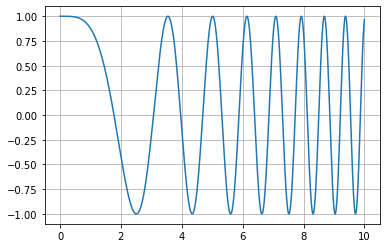

In [92]:
import numpy as np

def ryChirp(t, α=1):
    θ= 1/2 * α * t**2
    x= np.cos(θ)
    return x
t= np.linspace(0,10, 10001)
x= ryChirp(t)

pl.plot(t, x)
pl.grid()


For the above signal,
$\omega(t)=\alpha \cdot t $ (rad/sec)

How do we design an algorithm,
which generates a signal with frequency ranging from $\omega_0$ to $\omega_1$ smoothly?

![](fg/fg_chirp.png)
![](fg/fg_chirp2.png)

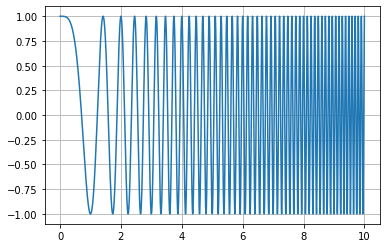

In [93]:
import numpy as np

def ryChirp(t, ω0=0, ω1= 10*2*np.pi, γ=0):
    α= (ω1-ω0)/(t[-1]-t[0])
    β= ω0 - α*t[0]
    θ= 1/2 * α * t**2 + β*t + γ
    x= np.cos(θ)
    return x

t= np.linspace(0,10,10001)
x= ryChirp(t)
pl.plot(t,x)
pl.grid()

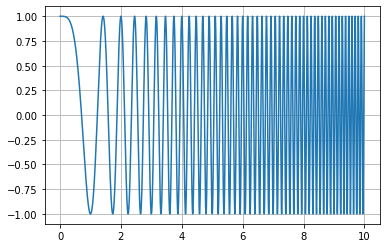

In [112]:
def ryChirp(t, f0= 0, f1= 100, γ= 0):
    
    ω0= f0*2*np.pi
    ω1= f1*2*np.pi
    
    α= (ω1-ω0)/(t[-1]-t[0])
    β= ω0 - α*t[0]
    
    θ= 1/2 * α * t**2 + β*t + γ
    x= np.cos(θ)
    return x

t= np.linspace(0,10,10001)
x= ryChirp(t,0,10)
pl.plot(t,x)
pl.grid()

In [113]:
from IPython.display import Audio
Audio(x, rate=10000)

Before we go on, let’s see how Chirp is implemented. Here is the class definition:

```python
class Chirp(Signal):
    
    def __init__(self, start=440, end=880, amp=1.0):
        self.start = start
        self.end = end
        self.amp = amp
```

start and end are the frequencies, in Hz, at the start and end of the chirp. amp is amplitude.

Here is the function that evaluates the signal:

```python
    def evaluate(self, ts):
        freqs = np.linspace(self.start, self.end, len(ts)-1)
        return self._evaluate(ts, freqs)
```

ts is the sequence of points in time where the signal should be evaluated; to keep this function simple, I assume they are equally-spaced.

If the length of ts is n, you can think of it as a sequence of n−1 intervals of time. To compute the frequency during each interval, I use np.linspace, which returns a NumPy array of n−1 values between start and end.

_evaluate is a private method that does the rest of the math1:

```python
    def _evaluate(self, ts, freqs):
        dts = np.diff(ts)
        dphis = PI2 * freqs * dts
        phases = np.cumsum(dphis)
        phases = np.insert(phases, 0, 0)
        ys = self.amp * np.cos(phases)
        return ys
```

np.diff computes the difference between adjacent elements of ts, returning the length of each interval in seconds. If the elements of ts are equally spaced, the dts are all the same.

The next step is to figure out how much the phase changes during each interval. In Section 1.7 we saw that when frequency is constant, the phase, φ, increases linearly over time:

$
φ = 2 π f t 
$

When frequency is a function of time, the change in phase during a short time interval, Δ t, is:

$
Δ φ = 2 π f(t) Δ t 
$

In Python, since freqs contains f(t) and dts contains the time intervals, we can write

```python
dphis = PI2 * freqs * dts
```

Now, since dphis contains the changes in phase, we can get the total phase at each timestep by adding up the changes:

```python
phases = np.cumsum(dphis)
phases = np.insert(phases, 0, 0)
```

np.cumsum computes the cumulative sum, which is almost what we want, but it doesn’t start at 0. So I use np.insert to add a 0 at the beginning.

The result is a NumPy array where the $i^{th}$ element contains the sum of the first i terms from dphis; that is, the total phase at the end of the ith interval. 

Finally, np.cos computes the amplitude of the wave as a function of phase (remember that phase is expressed in radians).

If you know calculus, you might notice that the limit as Δ t gets small is

$
dφ = 2 π f(t) dt 
$

Dividing through by dt yields

$
\frac{dφ}{dt} = 2 π f(t) 
$

In other words, frequency is the derivative of phase. Conversely, phase is the integral of frequency. When we used cumsum to go from frequency to phase, we were approximating integration.

## 3.2  Exponential chirp

When you listen to this chirp, you might notice that the pitch rises quickly at first and then slows down. The chirp spans two octaves, but it only takes 2/3 s to span the first octave, and twice as long to span the second.

The reason is that our perception of pitch depends on the logarithm of frequency. As a result, the interval we hear between two notes depends on the ratio of their frequencies, not the difference. “Interval” is the musical term for the perceived difference between two pitches.

For example, an octave is an interval where the ratio of two pitches is 2. So the interval from 220 to 440 is one octave and the interval from 440 to 880 is also one octave. The difference in frequency is bigger, but the ratio is the same.

As a result, if frequency increases linearly, as in a linear chirp, the perceived pitch increases logarithmically.

If you want the perceived pitch to increase linearly, the frequency has to increase exponentially. A signal with that shape is called an exponential chirp.

Here’s the code that makes one:

```python
class ExpoChirp(Chirp):
    
    def evaluate(self, ts):
        start, end = np.log10(self.start), np.log10(self.end)
        freqs = np.logspace(start, end, len(ts)-1)
        return self._evaluate(ts, freqs)
```

Instead of np.linspace, this version of evaluate uses np.logspace, which creates a series of frequencies whose logarithms are equally spaced, which means that they increase exponentially.

That’s it; everything else is the same as Chirp. Here’s the code that makes one:

```python
    signal = thinkdsp.ExpoChirp(start=220, end=880)
    wave = signal.make_wave(duration=1)
```

You can listen to these examples in chap03.ipynb and compare the linear and exponential chirps.

## 3.3  Spectrum of a chirp

![](http://greenteapress.com/thinkdsp/html/thinkdsp013.png)
Figure 3.2: Spectrum of a one-second one-octave chirp.

----

What do you think happens if you compute the spectrum of a chirp? Here’s an example that constructs a one-second, one-octave chirp and its spectrum:

```python
    signal = thinkdsp.Chirp(start=220, end=440)
    wave = signal.make_wave(duration=1)
    spectrum = wave.make_spectrum()
```

Figure 3.2 shows the result. 

The spectrum has components at every frequency from 220 to 440 Hz, with variations that look a little like the Eye of Sauron (see http://en.wikipedia.org/wiki/Sauron).

The spectrum is approximately flat between 220 and 440 Hz, which indicates that the signal spends equal time at each frequency in this range. Based on that observation, you should be able to guess what the spectrum of an exponential chirp looks like.

The spectrum gives hints about the structure of the signal, but it obscures the relationship between frequency and time. For example, we cannot tell by looking at this spectrum whether the frequency went up or down, or both.

## 3.4  Spectrogram

![](http://greenteapress.com/thinkdsp/html/thinkdsp014.png)

Figure 3.3: Spectrogram of a one-second one-octave chirp.

----

To recover the relationship between frequency and time, we can break the chirp into segments and plot the spectrum of each segment. The result is called a short-time Fourier Transform (STFT).

There are several ways to visualize a STFT, but the most common is a spectrogram, which shows time on the x-axis and frequency on the y-axis. Each column in the spectrogram shows the spectrum of a short segment, using color or grayscale to represent amplitude.

As an example, I’ll compute the spectrogram of this chirp:

```python
signal = thinkdsp.Chirp(start=220, end=440)
wave = signal.make_wave(duration=1, framerate=11025)
```
Wave provides make_spectrogram, which returns a Spectrogram object:


```python
spectrogram = wave.make_spectrogram(seg_length=512)
spectrogram.plot(high=700)
```

seg_length is the number of samples in each segment. I chose 512 because FFT is most efficient when the number of samples is a power of 2.

Figure 3.3 shows the result. 

The x-axis shows time from 0 to 1 seconds. The y-axis shows frequency from 0 to 700 Hz. I cut off the top part of the spectrogram; the full range goes to 5512.5 Hz, which is half of the frame rate.

The spectrogram shows clearly that frequency increases linearly over time. However, notice that the peak in each column is blurred across 2–3 cells. This blurring reflects the limited resolution of the spectrogram.

## 3.5  The Gabor limit

The time resolution of the spectrogram is the duration of the segments, which corresponds to the width of the cells in the spectrogram. Since each segment is 512 frames, and there are 11,025 frames per second, the duration of each segment is about 0.046 seconds.

The frequency resolution is the frequency range between elements in the spectrum, which corresponds to the height of the cells. With 512 frames, we get 256 frequency components over a range from 0 to 5512.5 Hz, so the range between components is 21.6 Hz.

More generally, if n is the segment length, the spectrum contains n/2 components. If the frame rate is r, the maximum frequency in the spectrum is r/2. So the time resolution is n/r and the frequency resolution is

$
\frac{r/2}{n/2}
$

which is r/n.

Ideally we would like time resolution to be small, so we can see rapid changes in frequency. And we would like frequency resolution to be small so we can see small changes in frequency. But you can’t have both. Notice that time resolution, n/r, is the inverse of frequency resolution, r/n. So if one gets smaller, the other gets bigger.

For example, if you double the segment length, you cut frequency resolution in half (which is good), but you double time resolution (which is bad). Even increasing the frame rate doesn’t help. You get more samples, but the range of frequencies increases at the same time.

This tradeoff is called the `Gabor limit` and it is a fundamental limitation of this kind of time-frequency analysis.

## 3.6  Leakage

![](http://greenteapress.com/thinkdsp/html/thinkdsp015.png)

Figure 3.4: Spectrum of a periodic segment of a sinusoid (left), a non-periodic segment (middle), a windowed non-periodic segment (right).

----

In order to explain how make_spectrogram works, I have to explain windowing; and in order to explain windowing, I have to show you the problem it is meant to address, which is leakage.

The Discrete Fourier Transform (DFT), which we use to compute Spectrums, treats waves as if they are periodic; that is, it assumes that the finite segment it operates on is a complete period from an infinite signal that repeats over all time. In practice, this assumption is often false, which creates problems.

One common problem is discontinuity at the beginning and end of the segment. Because DFT assumes that the signal is periodic, it implicitly connects the end of the segment back to the beginning to make a loop. If the end does not connect smoothly to the beginning, the discontinuity creates additional frequency components in the segment that are not in the signal.

As an example, let’s start with a sine signal that contains only one frequency component at 440 Hz.

```python
    signal = thinkdsp.SinSignal(freq=440)
```

If we select a segment that happens to be an integer multiple of the period, the end of the segment connects smoothly with the beginning, and DFT behaves well.

```python
    duration = signal.period * 30
    wave = signal.make_wave(duration)
    spectrum = wave.make_spectrum()
```

Figure 3.4 (left) shows the result. As expected, there is a single peak at 440 Hz.

But if the duration is not a multiple of the period, bad things happen. With duration = signal.period * 30.25, the signal starts at 0 and ends at 1.

Figure 3.4 (middle) shows the spectrum of this segment. Again, the peak is at 440 Hz, but now there are additional components spread out from 240 to 640 Hz. This spread is called `spectral leakage`, because some of the energy that is actually at the fundamental frequency leaks into other frequencies.

In this example, leakage happens because we are using DFT on a segment that becomes discontinuous when we treat it as periodic.

## 3.7  Windowing

![](http://greenteapress.com/thinkdsp/html/thinkdsp016.png)
Figure 3.5: Segment of a sinusoid (top), Hamming window (middle), product of the segment and the window (bottom).

----

We can reduce leakage by smoothing out the discontinuity between the beginning and end of the segment, and one way to do that is windowing.

A “window” is a function designed to transform a non-periodic segment into something that can pass for periodic. Figure 3.5 (top) shows a segment where the end does not connect smoothly to the beginning.

Figure 3.5 (middle) shows a “Hamming window”, one of the more common window functions. No window function is perfect, but some can be shown to be optimal for different applications, and Hamming is a good, all-purpose window.

Figure 3.5 (bottom) shows the result of multiplying the window by the original signal. Where the window is close to 1, the signal is unchanged. Where the window is close to 0, the signal is attenuated. Because the window tapers at both ends, the end of the segment connects smoothly to the beginning.

Figure 3.4 (right) shows the spectrum of the windowed signal. Windowing has reduced leakage substantially, but not completely.

Here’s what the code looks like. Wave provides window, which applies a Hamming window:

```python
class Wave:
    def window(self, window):
        self.ys *= window
```

And NumPy provides hamming, which computes a Hamming window with a given length:

```python
window = np.hamming(len(wave))
wave.window(window)
```

NumPy provides functions to compute other window functions, including bartlett, blackman, hanning, and kaiser. One of the exercises at the end of this chapter asks you to experiment with these other windows.

## 3.8  Implementing spectrograms

![](http://greenteapress.com/thinkdsp/html/thinkdsp017.png)

Figure 3.6: Overlapping Hamming windows.

----

Now that we understand windowing, we can understand the implementation of make_spectrogram. Here is the Wave method that computes spectrograms:

```python
class Wave:
    def make_spectrogram(self, seg_length):
        window = np.hamming(seg_length)
        i, j = 0, seg_length
        step = seg_length / 2

        spec_map = {}

        while j < len(self.ys):
            segment = self.slice(i, j)
            segment.window(window)

            t = (segment.start + segment.end) / 2
            spec_map[t] = segment.make_spectrum()

            i += step
            j += step

        return Spectrogram(spec_map, seg_length)
```

This is the longest function in the book, so if you can handle this, you can handle anything.

The parameter, self, is a Wave object. seg_length is the number of samples in each segment.

window is a Hamming window with the same length as the segments.

i and j are the slice indices that select segments from the wave. step is the offset between segments. Since step is half of seg_length, the segments overlap by half. Figure 3.6 shows what these overlapping windows look like.

spec_map is a dictionary that maps from a timestamp to a Spectrum.

Inside the while loop, we select a slice from the wave and apply the window; then we construct a Spectrum object and add it to spec_map. The nominal time of each segment, t, is the midpoint.

Then we advance i and j, and continue as long as j doesn’t go past the end of the Wave.

Finally, the method constructs and returns a Spectrogram object. Here is the definition of the class:

```python
class Spectrogram(object):
    def __init__(self, spec_map, seg_length):
        self.spec_map = spec_map
        self.seg_length = seg_length
```

Like many init methods, this one just stores the parameters as attributes.

Spectrogram provides plot, which generates a pseudocolor plot with time along the x-axis and frequency along the y-axis.

And that’s how Spectrograms are implemented.

## 3.9  Exercises

Solutions to these exercises are in chap03soln.ipynb.

Exercise 1   Run and listen to the examples in chap03.ipynb, which is in the repository for this book, and also available at http://tinyurl.com/thinkdsp03.
In the leakage example, try replacing the Hamming window with one of the other windows provided by NumPy, and see what effect they have on leakage. See http://docs.scipy.org/doc/numpy/reference/routines.window.html

Exercise 2   Write a class called SawtoothChirp that extends Chirp and overrides evaluate to generate a sawtooth waveform with frequency that increases (or decreases) linearly.
Hint: combine the evaluate functions from Chirp and SawtoothSignal.

Draw a sketch of what you think the spectrogram of this signal looks like, and then plot it. The effect of aliasing should be visually apparent, and if you listen carefully, you can hear it.

Exercise 3   Make a sawtooth chirp that sweeps from 2500 to 3000 Hz, then use it to make a wave with duration 1 s and frame rate 20 kHz. Draw a sketch of what you think the spectrum will look like. Then plot the spectrum and see if you got it right.
Exercise 4   In musical terminology, a “glissando” is a note that slides from one pitch to another, so it is similar to a chirp.
Find or make a recording of a glissando and plot a spectrogram of the first few seconds. One suggestion: George Gershwin’s Rhapsody in Blue starts with a famous clarinet glissando, which you can download from http://archive.org/details/rhapblue11924.

Exercise 5   A trombone player can play a glissando by extending the trombone slide while blowing continuously. As the slide extends, the total length of the tube gets longer, and the resulting pitch is inversely proportional to length.
Assuming that the player moves the slide at a constant speed, how does frequency vary with time?

Write a class called TromboneGliss that extends Chirp and provides evaluate. Make a wave that simulates a trombone glissando from C3 up to F3 and back down to C3. C3 is 262 Hz; F3 is 349 Hz.

Plot a spectrogram of the resulting wave. Is a trombone glissando more like a linear or exponential chirp?

Exercise 6   Make or find a recording of a series of vowel sounds and look at the spectrogram. Can you identify different vowels?
1
Beginning a method name with an underscore makes it “private”, indicating that it is not part of the API that should be used outside the class definition.